# Create Dutch Election Debate 21 Corpus

This notebook creates the dataset from the Dutch Election Debate 21 (DED21) corpus (see this [blog post](https://stukroodvlees.nl/welke-lijsttrekkers-lacht-het-meest-en-hoe/) for details). The corpus consists of a single video file (with audio signal) that is 1.45 hours long. The video features six Dutch party candidates, two moderators, and speakers from the audience. The audio signal has been annotated to the extent that all speech segments of the six party candidates are labeled.

To run the notebook, the folder `dutch-debate-corpus` needs to be in the same directory.

In [1]:
from copy import deepcopy
from moviepy.editor import VideoFileClip
from rttm import RttmObj, RttmSeq
from scipy.io import wavfile
import pandas as pd
import numpy as np
import seaborn as sns
import os

DATA_DIR = "dutch-debate-corpus"
NUM_PARTS = 2


In [2]:
def cut_time(time):
    time_split = str(time).split(":")
    if len(time_split) == 2 or (time_split[-1] == "00" and time_split[0] != "01"):
        out = "00:" + ":".join(time_split[:2])
    else:
        out = ":".join(time_split[:3])
    return out


The annotation file is read and the start and end time stamps of the labeled speech segments are extracted.

In [3]:
speaker_turns = pd.read_csv(os.path.join(DATA_DIR, "speaking_turns.csv"))
speaker_turns["audio_start"] = pd.to_timedelta(
    speaker_turns["audio.start"].apply(cut_time))
speaker_turns["audio_end"] = pd.to_timedelta(
    speaker_turns["audio.end"].apply(cut_time))


The extracted annotations are converted into RTTM format and saved as a reference file.

In [4]:
segments = []

for row in speaker_turns.itertuples():
    if not pd.isna(row.spkr_name) and not pd.isna(row.audio_start) and not pd.isna(row.audio_end):
        new_segment = RttmObj(
            type="SPEAKER",
            file=os.path.join(DATA_DIR, "ded21_audio.wav"),
            chnl=1,
            tbeg=float(row.audio_start.seconds),
            tdur=float(row.audio_end.seconds) - float(row.audio_start.seconds),
            ortho=None,
            stype=None,
            name=row.spkr_name,
            conf=None
        )
        segments.append(new_segment)

rttm_seq = RttmSeq(sequence=segments).sort()


In [5]:
print(rttm_seq)


type	file	chnl	tbeg	tdur	ortho	stype	name	conf	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	343.0	34.0	<NA>	<NA>	Wilders	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	381.0	32.0	<NA>	<NA>	Marijnissen	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	417.0	30.0	<NA>	<NA>	Hoekstra	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	450.0	33.0	<NA>	<NA>	Kaag	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	485.0	32.0	<NA>	<NA>	Rutte	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	521.0	28.0	<NA>	<NA>	Klaver	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	572.0	43.0	<NA>	<NA>	Kaag	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	638.0	75.0	<NA>	<NA>	Rutte	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	715.0	48.0	<NA>	<NA>	Wilders	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	769.0	44.0	<NA>	<NA>	Hoekstra	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	819.0	61.0	<NA>	<NA>	Marijnissen	<NA>	
SPEAKER	dutch-debate-corpus\ded21_audio.wav	1	908.0	79.0	<NA>	

In [6]:
duration = rttm_seq.get_duration()
split_time = rttm_seq.sequence[np.argmin([np.abs(duration/NUM_PARTS - seg.tbeg) for seg in rttm_seq.sequence])].tbeg

In [7]:
rttm_sub_seqs = rttm_seq.split([split_time])

The audio signal is separated from the video file and saved. To avoid memory allocation issues, the audio file was split at the segment that was closest to half of the duration. The audio signals were converted to mono to meet the requirements of the speaker diarizaton pipelines.

In [8]:
def convert_video_to_audio(video_file, audio_file, split_time, sample_rate=16000):
    with VideoFileClip(video_file) as clip:
        duration = clip.duration
        for i, end in enumerate(split_time + [duration]):
            filename = f"_{i}.".join(audio_file.split("."))
            if i == 0:
                start = 0.0
            else:
                start = split_time[i-1]
            subclip = clip.subclip(start, end)
            print(filename)
            subclip.audio.write_audiofile(filename, fps=sample_rate, ffmpeg_params=["-ac", "1"]) # convert to mono

    print(f"Converted video file {video_file} to audio file {filename}")


In [9]:
convert_video_to_audio(os.path.join(DATA_DIR, "ded21_video.mp4"),
                       os.path.join(DATA_DIR, "ded21_audio.wav"),
                       [split_time])


dutch-debate-corpus\ded21_audio_0.wav
MoviePy - Writing audio in dutch-debate-corpus\ded21_audio_0.wav


MoviePy - Done.
dutch-debate-corpus\ded21_audio_1.wav
MoviePy - Writing audio in dutch-debate-corpus\ded21_audio_1.wav


MoviePy - Done.
Converted video file dutch-debate-corpus\ded21_video.mp4 to audio file dutch-debate-corpus\ded21_audio_1.wav


The labeled segments are extracted from the audio signal. Instead of cutting them together right after each other, a short white noise segment is inserted in between the segments to simulated non-speech segments. The white noise segments have a random length between 1s and 5s. A new RTTM file is created that contains the reference for the new audio signal.

In [10]:
def generate_white_noise(size, amplitude):
    return amplitude*np.random.normal(0.0, 1.0, size=size).astype(np.int16)


In [11]:
def segment_audio(audio_file, rttm_seq):
    sample_rate, signal = wavfile.read(audio_file)
    amplitude = np.iinfo(np.int16).max
    new_signal = np.zeros((0), dtype=np.int16)
    new_rttm_seq = deepcopy(rttm_seq)

    for i, seg in enumerate(rttm_seq.sequence):
        start_frame = int(seg.tbeg*sample_rate)
        end_frame = int((seg.tbeg+seg.tdur)*sample_rate)
        noise_dur = np.random.choice(5)+1
        new_signal = np.append(new_signal, generate_white_noise(
            (int(sample_rate*noise_dur)), amplitude), axis=0)
        new_signal = np.append(
            new_signal, signal[start_frame:end_frame], axis=0)
        new_seg = new_rttm_seq.sequence[i]

        if i == 0:
            new_seg.tbeg = noise_dur
        else:
            new_prev_seg = new_rttm_seq.sequence[i-1]
            new_seg.tbeg = new_prev_seg.tbeg+new_prev_seg.tdur + noise_dur

    wavfile.write(audio_file, sample_rate, new_signal)

    return new_rttm_seq


In [12]:
np.random.seed(10)

new_rttm_sub_seqs = [segment_audio(os.path.join(
    DATA_DIR, f"ded21_audio_{i}.wav"), seq) for i, seq in enumerate(rttm_sub_seqs)]


In [13]:
for i, seq in enumerate(new_rttm_sub_seqs):
    seq_copy = deepcopy(seq)
    for seg in seq_copy.sequence:
        seg.file = os.path.join(DATA_DIR, f"ref_ded21_audio_{i}.wav")
    seq_copy.write(os.path.join(DATA_DIR, f"ref_ded21_audio_{i}.rttm"))


[]

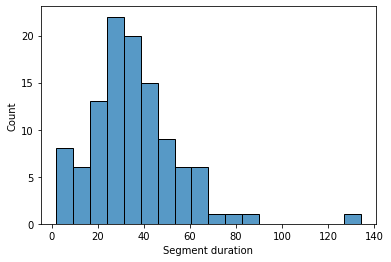

In [14]:
durations = [seg.tdur for seg in rttm_seq.sequence]

plot = sns.histplot(data=durations)
plot.set(xlabel="Segment duration")
plot.plot()


[]

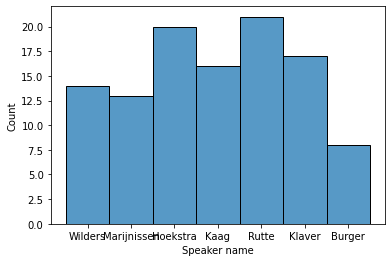

In [15]:
speakers = [seg.name for seg in rttm_seq.sequence]

plot = sns.histplot(data=speakers)
plot.set(xlabel="Speaker name")
plot.plot()


[]

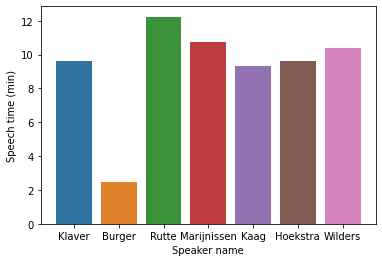

In [16]:
speaker_time = []

for spk in set(speakers):
    speaker_time.append(
        sum([dur for i, dur in enumerate(durations) if speakers[i] == spk])/60.0)

plot = sns.barplot(data={"time": speaker_time, "speaker": list(
    set(speakers))}, x="speaker", y="time")
plot.set(xlabel="Speaker name", ylabel="Speech time (min)")
plot.plot()
